## 정규성 검정

### 11-1-1 벤치마크 자료 분석

시간 s와 t(s<t)사이의 로그수익률 $\log{\frac{S_t}{S_s}} = \log S_t-\log S_s$은 정규분포를 이룸 \
임의의 시간 t에서 $S_t$는 정규분포를 이룸

In [1]:
import numpy as np
np.random.seed(1000)
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def gen_paths(s0,r,sigma,T,M,I):
    ''' 기하 브라운 운동 모형에 대한 몬테카를로 경로 생성
    
    input
    ====
    s0 : float 초기값
    r : float 고정 단기 이자율
    sigma : float 고정 변동성
    T : float 만기
    M : int 시간 구간 수
    I : int 생성 경로 수
    
    output
    ====
    paths : ndarray,  shape(M+1,I) 주어진 인수
    '''
    dt = float(T)/M
    paths = np.zeros((M+1,I),np.float64)
    paths[0] = s0
    for t in range(1,M+1):
        rand = np.random.standard_normal(I)
        rand = (rand-rand.mean())/rand.std()  #분산 감소
        paths[t] = paths[t-1]*np.exp((r-0.5*sigma**2)*dt +
                                   sigma*np.sqrt(dt)*rand)
    return paths

In [13]:
#example
s0 = 100.
r = 0.05
sigma = 0.2
T = 1.0
M = 50
I = 250000
paths = gen_paths(s0,r,sigma,T,M,I)

Text(0.5, 1.0, '10 geometric Brown simulation paths')

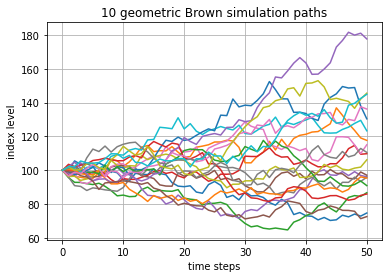

In [14]:
plt.plot(paths[:,:20])
plt.grid(True)
plt.xlabel('time steps')
plt.ylabel('index level')
plt.title('10 geometric Brown simulation paths')

In [15]:
#로그수익률
log_returns = np.log(paths[1:]/paths[0:-1])

In [17]:
paths[:,0].round(4)

array([100.    ,  99.8259, 105.5592, 103.5351, 103.8765, 102.3455,
        97.037 ,  99.1677,  99.4746,  98.5531,  94.5731,  93.7886,
        98.2344,  97.6286,  97.486 , 100.8205,  98.0797,  97.4243,
        92.7311,  90.6651,  90.3353,  90.8615,  87.1551,  86.4598,
        91.5802,  93.4092,  91.1497,  84.0041,  85.2314,  82.537 ,
        87.1883,  84.9163,  85.1076,  83.972 ,  80.9482,  79.4321,
        82.8784,  80.7593,  73.8754,  75.067 ,  73.1602,  72.8452,
        70.7244,  72.1584,  70.3929,  70.7764,  73.492 ,  72.5211,
        74.1716,  72.9681,  74.7846])

In [18]:
log_returns[:,0].round(4)

array([-0.0017,  0.0558, -0.0194,  0.0033, -0.0148, -0.0533,  0.0217,
        0.0031, -0.0093, -0.0412, -0.0083,  0.0463, -0.0062, -0.0015,
        0.0336, -0.0276, -0.0067, -0.0494, -0.0225, -0.0036,  0.0058,
       -0.0416, -0.008 ,  0.0575,  0.0198, -0.0245, -0.0816,  0.0145,
       -0.0321,  0.0548, -0.0264,  0.0023, -0.0134, -0.0367, -0.0189,
        0.0425, -0.0259, -0.0891,  0.016 , -0.0257, -0.0043, -0.0295,
        0.0201, -0.0248,  0.0054,  0.0377, -0.0133,  0.0225, -0.0164,
        0.0246])

In [19]:
#주어진 data로 자료의 평균,왜도,첨도 등 통계 출력
def print_statistics(array):
    '''통계치 출력
    input
    ====
    array : ndarray 통계치 계산 자료
    '''
    sta = scs.describe(array)
    print("%14s %15s" %('statistic','value'))
    print(30*'-')
    print('%14s %15.5f' % ('size',sta[0]))
    print('%14s %15.5f' % ('min',sta[1][0]))
    print('%14s %15.5f' % ('max',sta[1][1]))
    print('%14s %15.5f' % ('mean',sta[2]))
    print('%14s %15.5f' % ('std',np.sqrt(sta[3])))
    print('%14s %15.5f' % ('skew',sta[4])) #왜도
    print('%14s %15.5f' % ('kurtosis',sta[5])) #첨도

In [21]:
print_statistics(log_returns.flatten())  #flatten -> n차원 > 1차원 자료로 변환

     statistic           value
------------------------------
          size  12500000.00000
           min        -0.14581
           max         0.14723
          mean         0.00060
           std         0.02828
          skew         0.00043
      kurtosis         0.00001


연율화 시 mean = 0.0006x50(0.03), std = 0.02828*$\sqrt{50}$(0.2)

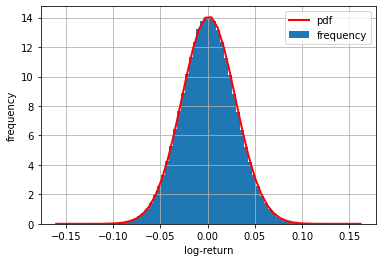

In [29]:
#시뮬레이션된 로그수익률 분포와 주어진 r,sigma에 대한 정규분포의 확률 밀도 함수 비교 (거의 비슷)

plt.hist(log_returns.flatten(),bins = 70, density = True, label = 'frequency')  #normed >density
plt.grid(True)
plt.xlabel('log-return')
plt.ylabel('frequency')
x = np.linspace(plt.axis()[0],plt.axis()[1])
plt.plot(x,scs.norm.pdf(x, loc = r/M, scale = sigma/np.sqrt(M)),
         'r', lw = 2.0, label = 'pdf')
plt.legend()

확률 밀도함수(pdf)와 실제 히스토그램 비교 외의 시각적인 정규성 테스트 \
분위수 대조도 (Q-Q plots) : 샘플값의 샘플 분위수와 정규분포 상의 이론적 분위수 비교

Text(0, 0.5, 'sample quantiles')

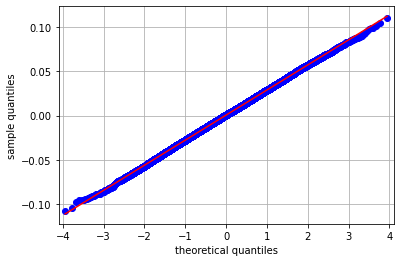

In [31]:
#샘플 자료가 정규분포 가짐 > 대다수의 분위수 값의 쌍이 일직선 이룸
sm.qqplot(log_returns.flatten()[::500],line = 's')
plt.grid(True)
plt.xlabel('theoretical quantiles') #샘플 분위수
plt.ylabel('sample quantiles') #이론 분위수

In [35]:
#세 가지 통계적 검정결과 (왜도,첨도,정규성)
def normality_test(arr):
    ''' 주어진 데이터가 정규분포인지 검정
    input
    ====
    array : ndarray 통계치 생성할 대상
    '''
    print('Skew of data set %14.3f' % scs.skew(arr))  #왜도
    print('Skew test p-value %14.3f' % scs.skewtest(arr)[1])
    print('kurt of data set %14.3f' % scs.skew(arr))  #첨도(초과첨도)
    print('kurt test p-value %14.3f' % scs.skewtest(arr)[1])
    print('Norm test p-value %14.3f' % scs.skewtest(arr)[1]) #정규성

In [36]:
normality_test(log_returns.flatten())  #유의확률 0.05이상이므로 로그수익률이 정규분포임을 나타낸다

Skew of data set          0.000
Skew test p-value          0.534
kurt of data set          0.000
kurt test p-value          0.534
Norm test p-value          0.534


아래의 첨도 정의에 따르면 정규분포 첨도는 3. 책에서는 초과첨도(excess kurtosis)를 첨도로 부름\
$Kurt[X] = \frac{\mu_4}{\sigma_4} = \frac{E[(X-\mu)^4]}{E[(X-\mu)^2]^2} $

Text(0.5, 1.0, 'log data')

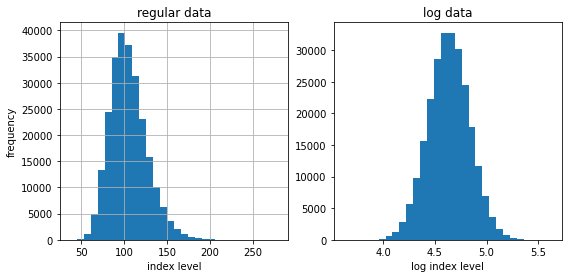

In [37]:
#만기값이 로그 정규분포인지 확인 (수익률 분포는 정규분포, 가격 분포는 로그정규분포를 따름)
f,(ax1,ax2) = plt.subplots(1,2,figsize = (9,4))

ax1.hist(paths[-1],bins = 30)
ax1.grid(True)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax1.set_title('regular data')

ax2.hist(np.log(paths[-1]),bins = 30)  #로그변환
ax2.set_xlabel('log index level')
ax2.set_title('log data')

In [38]:
print_statistics(paths[-1])

     statistic           value
------------------------------
          size    250000.00000
           min        37.29225
           max       278.49956
          mean       105.13904
           std        21.30328
          skew         0.61715
      kurtosis         0.67440


In [39]:
print_statistics(np.log(paths[-1])) #로그변환값은 왜도,첨도값이 거의 0에 근사

     statistic           value
------------------------------
          size    250000.00000
           min         3.61879
           max         5.62942
          mean         4.63517
           std         0.20056
          skew         0.00121
      kurtosis         0.00288


In [40]:
normality_test(np.log(paths[-1])) #p값 : 0.08이상이므로 가설 강하게 지지

Skew of data set          0.001
Skew test p-value          0.804
kurt of data set          0.001
kurt test p-value          0.804
Norm test p-value          0.804


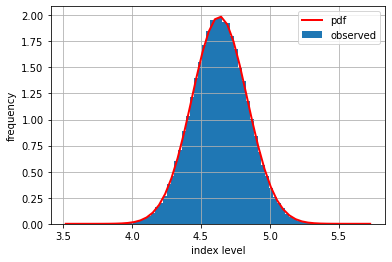

In [42]:
#norm pdf 실제 hist비교
log_data = np.log(paths[-1])

plt.hist(log_data,bins = 70, density = True, label = 'observed')
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')
x = np.linspace(plt.axis()[0],plt.axis()[1])
plt.plot(x,scs.norm.pdf(x,log_data.mean(),log_data.std()),
        'r',lw = 2.0,label='pdf')
plt.legend()

Text(0, 0.5, 'sample quantiles')

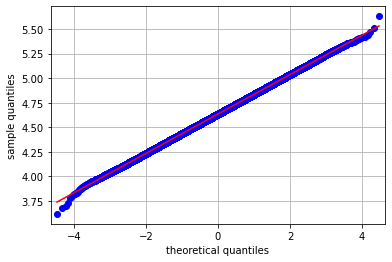

In [43]:
#Q-Q플롯으로 확인해도 정규분포 지지
sm.qqplot(log_data,line ='s')
plt.grid(True)
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

### 11-1-2 현실 자료 분석

In [68]:
import pandas as pd
from pandas_datareader import data as web

In [79]:
symbols = ['SPY','GLD','^GDAXI','MSFT']  #미국S&P 500지수, 금가격 추총, 마이크로소프트

In [89]:
#Adj Close(종가 조정치 - 배당, 주식 분할 등을 고려해 종가 변환 값) 읽기 
data = pd.DataFrame()
failed = []
for sym in symbols :
    try:
        data[sym] = web.DataReader(sym, data_source='yahoo',start ='2006-01-01', end = '2016-9-26')['Close']  #yahoo에서밖에 못가져옴
    except (IOError, KeyError):
        msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        failed.append(sym)  #어디가 안되는지 확인 책에있는 YHOO는 안받아짐

data = data.dropna()

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2657 entries, 2006-01-03 to 2016-09-26
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     2657 non-null   float64
 1   GLD     2657 non-null   float64
 2   ^GDAXI  2657 non-null   float64
 3   MSFT    2657 non-null   float64
dtypes: float64(4)
memory usage: 103.8 KB


In [91]:
data.head() 

,SPY,GLD,^GDAXI,MSFT
Date,,,,
2006-01-03,126.699997,53.119999,5460.680176,26.840000
2006-01-04,127.300003,53.299999,5523.620117,26.969999
2006-01-05,127.379997,52.340000,5516.529785,26.990000
2006-01-06,128.440002,53.720001,5536.319824,26.910000
2006-01-09,128.770004,54.599998,5537.109863,26.860001


<AxesSubplot:xlabel='Date'>

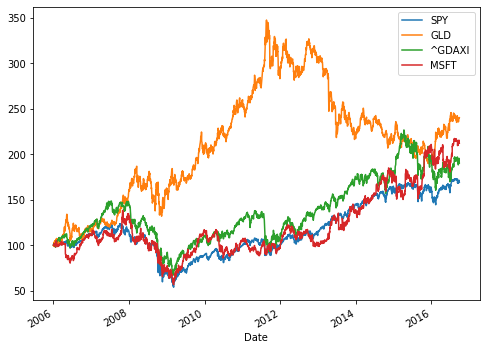

In [92]:
#절대값 수준이 다름 > 시작값을 100으로 정규화
(data/data.iloc[0]*100).plot(figsize = (8,6))  #ix사라짐 iloc사용

In [93]:
#pandas의 shift method사용 편리
log_returns = np.log(data/data.shift(1))
log_returns.head()

,SPY,GLD,^GDAXI,MSFT
Date,,,,
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,0.004724,0.003383,0.011460,0.004832
2006-01-05,0.000628,-0.018175,-0.001284,0.000741
2006-01-06,0.008287,0.026024,0.003581,-0.002968
2006-01-09,0.002566,0.016248,0.000143,-0.001860


C:\Users\dpwl0\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'SPY'}>,
        <AxesSubplot:title={'center':'GLD'}>],
       [<AxesSubplot:title={'center':'^GDAXI'}>,
        <AxesSubplot:title={'center':'MSFT'}>]], dtype=object)

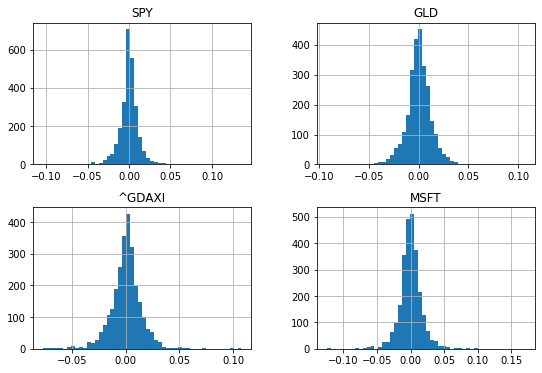

In [94]:
log_returns.hist(bins = 50, figsize = (9,6))

In [95]:
for sym in symbols:
    print('\nResults for symbol %s'%sym)
    print(30*'-')
    log_data = np.array(log_returns[sym].dropna())
    print_statistics(log_data #넷 다 첨도값에서 정규분포와 거리가 멀다


Results for symbol SPY
------------------------------
     statistic           value
------------------------------
          size      2656.00000
           min        -0.10364
           max         0.13558
          mean         0.00020
           std         0.01292
          skew        -0.07763
      kurtosis        13.19035

Results for symbol GLD
------------------------------
     statistic           value
------------------------------
          size      2656.00000
           min        -0.09191
           max         0.10697
          mean         0.00033
           std         0.01288
          skew        -0.27298
      kurtosis         5.33251

Results for symbol ^GDAXI
------------------------------
     statistic           value
------------------------------
          size      2656.00000
           min        -0.07739
           max         0.10797
          mean         0.00024
           std         0.01471
          skew        -0.05454
      kurtosis         5.4

Text(0, 0.5, 'sample quantiles')

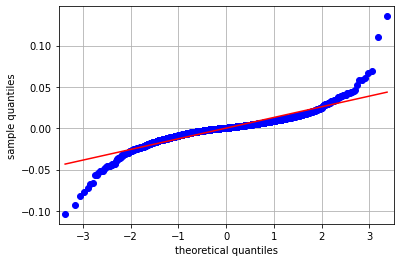

In [98]:
sm.qqplot(log_returns['SPY'].dropna(),line = 's')
plt.grid(True)
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

Text(0, 0.5, 'sample quantiles')

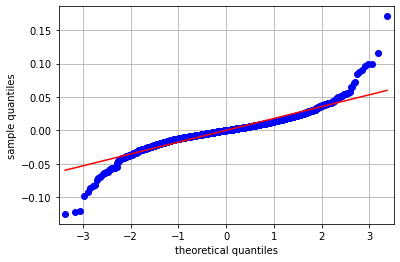

In [99]:
#마이크로소프트
sm.qqplot(log_returns['MSFT'].dropna(),line = 's')
plt.grid(True)
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

둘 다 강한 펫 테일(fat tail) 현상이 보임 \
펫 테일 현상 : 분포 양쪽의 이상치들이 정규분포보다 더 양수거나 음수인 경우

In [101]:
#정식 정규성 검정
for sym in symbols :
    print('\nResults for symbol %s'%sym)
    print(30*'-')
    log_data = np.array(log_returns[sym].dropna())
    normality_test(log_data)


Results for symbol SPY
------------------------------
Skew of data set         -0.078
Skew test p-value          0.102
kurt of data set         -0.078
kurt test p-value          0.102
Norm test p-value          0.102

Results for symbol GLD
------------------------------
Skew of data set         -0.273
Skew test p-value          0.000
kurt of data set         -0.273
kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol ^GDAXI
------------------------------
Skew of data set         -0.055
Skew test p-value          0.250
kurt of data set         -0.055
kurt test p-value          0.250
Norm test p-value          0.250

Results for symbol MSFT
------------------------------
Skew of data set          0.069
Skew test p-value          0.147
kurt of data set          0.069
kurt test p-value          0.147
Norm test p-value          0.147


정규분포를 따른다는 가정은 일반적으로 정당화 불가. \
점프확산모형이나 확률적 변동성 모형과 같은 확장모형 사용해야함